In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import numpy as np 
import pandas as pd
from tqdm import tqdm
import pickle
import torch
print(torch.__version__)
import os, random
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device avaiable:", device)

1.13.0
/kaggle/input/face-images-with-marked-landmark-points/facial_keypoints.csv
/kaggle/input/face-images-with-marked-landmark-points/face_images.npz
device avaiable: cuda


In [2]:
!nvidia-smi
!nvcc -V
print("_____"*30)

Mon Mar 17 19:29:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             13W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
with np.load('../input/face-images-with-marked-landmark-points/face_images.npz') as data:
    images = data['face_images']
df =  pd.read_csv('../input/face-images-with-marked-landmark-points/facial_keypoints.csv')
images = np.transpose(images, (2, 0, 1))
x = np.repeat(np.expand_dims(images, axis=1), 3, 1)
y = df.to_numpy() 

print(x.shape, y.shape) 

(7049, 3, 96, 96) (7049, 30)


In [4]:
# print("Before clean: ", len(x), len(y))
# list_remove = []
# for i in tqdm(range(len(x))):
#     if np.isnan(x[i]).any() or np.isnan(y[i]).any():
#         list_remove.append(i)

# x_new, y_new = [], []
# for i in tqdm(range(len(x))):
#     if i not in list_remove:
#         x_new.append(x[i])
#         y_new.append(y[i])

# x = np.asarray(x_new)
# y = np.asarray(y_new)

# print("After clean: ", len(x), len(y))

Before clean:  7049 7049


100%|██████████| 7049/7049 [00:00<00:00, 24227.09it/s]


After clean:  2140 2140


In [5]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self,image,label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = ((self.image[idx] / 255.) - 0.5) / 0.225
        label = (self.label[idx] / 96.)
        
        image = torch.as_tensor(image, dtype=torch.float16)
        label = torch.as_tensor(label, dtype=torch.float16)
        return image,label

In [6]:
rate = 0.7
x_train, x_val = x[:int(rate * len(x))], x[int(rate * len(x)):]
y_train, y_val = y[:int(rate * len(x))], y[int(rate * len(x)):]
print("train shape", x_train.shape, y_train.shape)
print("validate shape", x_val.shape, y_val.shape)

train shape (1498, 3, 96, 96) (1498, 30)
validate shape (642, 3, 96, 96) (642, 30)


In [7]:
batch_size = 64

In [8]:
train_loader = torch.utils.data.DataLoader(FaceDataset(x_train,y_train),shuffle = True, batch_size = batch_size, num_workers=2, pin_memory=True)
val_loader  = torch.utils.data.DataLoader(FaceDataset(x_val,y_val), shuffle = True, batch_size = batch_size, num_workers=2, pin_memory=True)

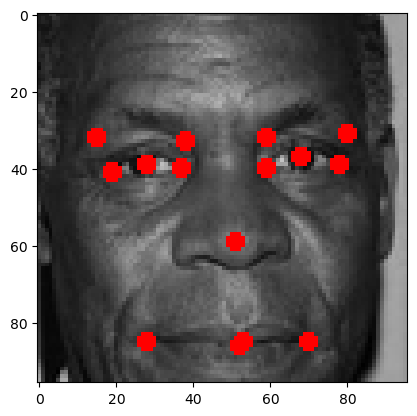

In [9]:
def show_image(x, y, index=0, pred = None):
    img = ((x[index] * 0.225) + 0.5) * 255
    img = np.transpose(np.asarray(img.cpu(), dtype=np.uint8), (1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(0,30,2):
        x1, y1 = int((y[index][i]) * img.shape[1]), int((y[index][i+1]) * img.shape[0])
        cv2.circle(img, (x1, y1), 1, (255, 0, 0), 2)
    if pred is not None:
        for i in range(0,30,2):
            x1, y1 = int((pred[index][i]) * img.shape[1]), int((pred[index][i+1]) * img.shape[0])
            cv2.circle(img, (x1, y1), 1, (0, 255, 0), 2)
    plt.imshow(img)



inputs, classes = next(iter(val_loader))   


index = int(random.randint(0, len(inputs)-1))
show_image(inputs, classes, index)

In [10]:
import math
import torch.nn as nn

class Divine2(nn.Module):
    def __init__(self, num_di = 5):
        super().__init__()
        self.divine = num_di
    def forward(self, x):
        return x / self.divine

class WingLoss(nn.Module):
    def __init__(self, omega=10, epsilon=2):
        super(WingLoss, self).__init__()
        self.omega = omega
        self.epsilon = epsilon

    def forward(self, pred, target):
        y = target
        y_hat = pred
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.omega]
        delta_y2 = delta_y[delta_y >= self.omega]
        loss1 = self.omega * torch.log(1 + delta_y1 / self.epsilon)
        C = self.omega - self.omega * math.log(1 + self.omega / self.epsilon)
        loss2 = delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))

class AdaptiveWingLoss(nn.Module):
    def __init__(self, omega=14, theta=0.5, epsilon=1, alpha=2.1):
        super(AdaptiveWingLoss, self).__init__()
        self.omega = omega
        self.theta = theta
        self.epsilon = epsilon
        self.alpha = alpha
 
    def forward(self, pred, target):
        
        y = target
        y_hat = pred
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.theta]
        delta_y2 = delta_y[delta_y >= self.theta]
        y1 = y[delta_y < self.theta]
        y2 = y[delta_y >= self.theta]
        loss1 = self.omega * torch.log(1 + torch.pow(delta_y1 / self.omega, self.alpha - y1))
        A = self.omega * (1 / (1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))) * (self.alpha - y2) * (
            torch.pow(self.theta / self.epsilon, self.alpha - y2 - 1)) * (1 / self.epsilon)
        C = self.theta * A - self.omega * torch.log(1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))
        loss2 = A * delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))


class L2Loss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(L2Loss, self).__init__()
        self.epsilon = epsilon
    def forward(self, pred, target):
        return torch.mean(((target - pred) ** 2) + self.epsilon, dim=1).mean() 

class L1Loss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(L1Loss, self).__init__()
        self.epsilon = epsilon
    def forward(self, pred, target):
        return torch.mean(torch.abs_(target - pred) + self.epsilon, dim=1).mean()
    

def get_lr(optimizer):
    for p in optimizer.param_groups:
        return p["lr"]


In [11]:
from torch.cuda.amp import autocast
import torch.optim as optim
from torch.cuda import amp
from tqdm import tqdm
import torchvision
import torch.nn.functional as F
from torch.cuda.amp import autocast
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

In [12]:

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.gelu = nn.GELU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.gelu(self.batch_norm1(self.conv1(x)))
        
        x = self.gelu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x+=identity
        x=self.gelu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.gelu = nn.GELU()

    def forward(self, x):
      identity = x.clone()

      x = self.gelu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.gelu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.gelu = nn.GELU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
    
    @autocast()
    def forward(self, x):
        x = self.gelu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

def ResNet18(num_classes, channels=3):
    return ResNet(Bottleneck, [2,2,2,2], num_classes, channels).apply(init_weights)
  
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels).apply(init_weights)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels).apply(init_weights)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels).apply(init_weights)


In [13]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )

def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()

    channels_per_group = num_channels // groups
    
    x = x.view(batchsize, groups, 
        channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()

    x = x.view(batchsize, -1, height, width)

    return x
    
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, benchmodel):
        super(InvertedResidual, self).__init__()
        self.benchmodel = benchmodel
        self.stride = stride
        assert stride in [1, 2]

        oup_inc = oup//2
        
        if self.benchmodel == 1:
            self.banch2 = nn.Sequential(
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.GELU(),
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.GELU()
            )
        else:
            self.banch1 = nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.GELU()
            )        
    
            self.banch2 = nn.Sequential(
                nn.Conv2d(inp, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.GELU(),
                nn.Conv2d(oup_inc, oup_inc, 3, stride, 1, groups=oup_inc, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.Conv2d(oup_inc, oup_inc, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup_inc),
                nn.GELU(),
            )
          
    @staticmethod
    def _concat(x, out):
        return torch.cat((x, out), 1)        

    def forward(self, x):
        if 1==self.benchmodel:
            x1 = x[:, :(x.shape[1]//2), :, :]
            x2 = x[:, (x.shape[1]//2):, :, :]
            out = self._concat(x1, self.banch2(x2))
        elif 2==self.benchmodel:
            out = self._concat(self.banch1(x), self.banch2(x))

        return channel_shuffle(out, 2)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)

class ShuffleNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(ShuffleNetV2, self).__init__()
        
        assert input_size % 32 == 0
        
        self.stage_repeats = [4, 8, 4]
        if width_mult == 0.5:
            self.stage_out_channels = [-1, 24,  48,  96, 192, 1024]
        elif width_mult == 1.0:
            self.stage_out_channels = [-1, 24, 116, 232, 464, 1024]
        elif width_mult == 1.5:
            self.stage_out_channels = [-1, 24, 176, 352, 704, 1024]
        elif width_mult == 2.0:
            self.stage_out_channels = [-1, 24, 224, 488, 976, 2048]
        else:
            raise ValueError(
                """{} groups is not supported for
                       1x1 Grouped Convolutions""".format(num_groups))

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.conv1 = conv_bn(3, input_channel, 2)
        # init.xavier_normal_(self.conv1.weight)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.features = []
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage+2]
            for i in range(numrepeat):
                if i == 0:
                    self.features.append(InvertedResidual(input_channel, output_channel, 2, 2))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, 1))
                input_channel = output_channel
                
        self.features = nn.Sequential(*self.features)

        self.conv_last = conv_1x1_bn(input_channel, self.stage_out_channels[-1])
        self.globalpool = nn.Sequential(nn.AvgPool2d(int(input_size/32)))              

        self.classifier = nn.Sequential(nn.Linear(self.stage_out_channels[-1], n_class))
        
        init_weights(self.classifier)
        init_weights(self.conv1)
        init_weights(self.conv_last) 
        init_weights(self.features)
        
    @autocast()
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.conv_last(x)
        x = self.globalpool(x)
        x = x.view(-1, self.stage_out_channels[-1])
        x = self.classifier(x)
        return x



In [14]:
epochs = 100
lr=1e-02
momentum=0.9
weight_decay=0.0005

In [15]:
def train(l_m, save_file="best_shufflenet_v2_wingl.pt"):
    funtion_l_l1 = L1Loss(0.) 
    opt = optim.SGD(models.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.5)
    best_loss_val, best_loss_val_epoch = float('inf'), 0
    models.to(device)
    his_loss_train, his_loss_val = [], []
    for epoch in range(1, epochs + 1):
        total_train, total_val, running_loss, loss_val = 0, 0, 0.0, 0.0
        models.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            ## forward
            outputs_model = models(inputs)
            ## loss
            loss = l_m(outputs_model, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item()
            total_train += len(inputs)
        running_loss = (running_loss/total_train) * 100
        his_loss_train.append(running_loss)
        loss_val = 0.0
        with torch.no_grad():

            models.eval()
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs_model = models(inputs)
                l_val = funtion_l_l1(outputs_model, labels)
                loss_val += l_val.item()
                total_val += len(inputs)
            loss_val = (loss_val/total_val) * 100
            if loss_val < best_loss_val:
                best_loss_val = loss_val
                torch.save(models.state_dict(), save_file)

        his_loss_val.append(loss_val)
        print("At epoch "+ str(epoch)+"/"+str(epochs)+". Total training loss: ", format(running_loss, '.6f'),  " current loss: ", format(loss_val, '.6f'), " learning rate", get_lr(opt), "current best validate loss: ", format(best_loss_val, '.6f'))
        ## update learning rate 
        if epoch % 10 == 0 and float(get_lr(opt)) > 1e-05:
            scheduler.step()
    plt.clf()
    plt.plot(his_loss_train)
    plt.plot(his_loss_val)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.suptitle("Loss/Epoch")
    plt.legend(["Train","Test"])
    plt.figure()
    plt.savefig(save_file+".png")
    with open(save_file.split(".")[0], "wb") as fp:
        pickle.dump(his_loss_val, fp)
        

At epoch 1/100. Total training loss:  0.677346  current loss:  0.260074  learning rate 0.01 current best validate loss:  0.260074
At epoch 2/100. Total training loss:  0.029922  current loss:  0.180814  learning rate 0.01 current best validate loss:  0.180814
At epoch 3/100. Total training loss:  0.011380  current loss:  0.147426  learning rate 0.01 current best validate loss:  0.147426
At epoch 4/100. Total training loss:  0.009731  current loss:  0.150677  learning rate 0.01 current best validate loss:  0.147426
At epoch 5/100. Total training loss:  0.008886  current loss:  0.144935  learning rate 0.01 current best validate loss:  0.144935
At epoch 6/100. Total training loss:  0.008548  current loss:  0.143585  learning rate 0.01 current best validate loss:  0.143585
At epoch 7/100. Total training loss:  0.008237  current loss:  0.139639  learning rate 0.01 current best validate loss:  0.139639
At epoch 8/100. Total training loss:  0.007852  current loss:  0.135932  learning rate 0.0

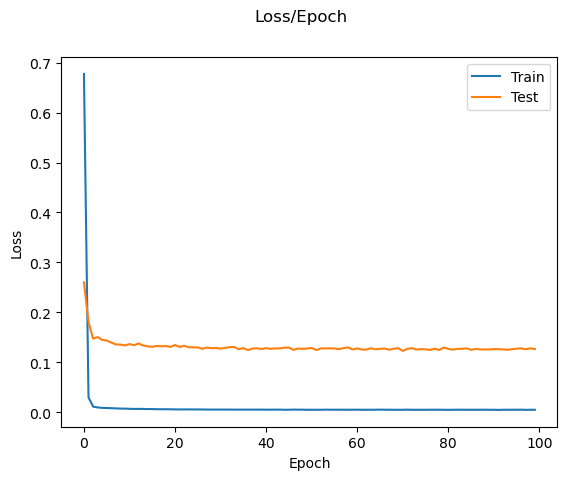

<Figure size 640x480 with 0 Axes>

In [16]:
models = ShuffleNetV2(n_class=30, input_size=96, width_mult=0.5)
l_m = AdaptiveWingLoss()
train(l_m, "best_shufflenet_v2_awingl.pt")

At epoch 1/100. Total training loss:  5.070432  current loss:  0.133165  learning rate 0.01 current best validate loss:  0.133165
At epoch 2/100. Total training loss:  2.218844  current loss:  0.851564  learning rate 0.01 current best validate loss:  0.133165
At epoch 3/100. Total training loss:  2.358451  current loss:  0.752910  learning rate 0.01 current best validate loss:  0.133165
At epoch 4/100. Total training loss:  2.308286  current loss:  0.693381  learning rate 0.01 current best validate loss:  0.133165
At epoch 5/100. Total training loss:  1.820754  current loss:  0.086714  learning rate 0.01 current best validate loss:  0.086714
At epoch 6/100. Total training loss:  1.267445  current loss:  0.096111  learning rate 0.01 current best validate loss:  0.086714
At epoch 7/100. Total training loss:  1.022098  current loss:  0.054390  learning rate 0.01 current best validate loss:  0.054390
At epoch 8/100. Total training loss:  0.771797  current loss:  0.295697  learning rate 0.0

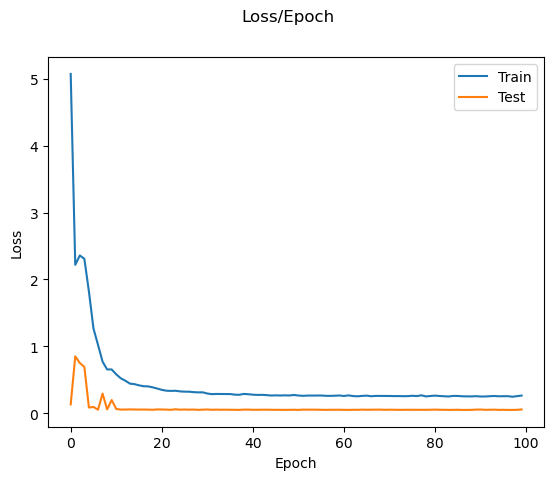

<Figure size 640x480 with 0 Axes>

In [17]:
models = ShuffleNetV2(n_class=30, input_size=96, width_mult=0.5)
l_m = WingLoss(omega=30, epsilon=2)
train(l_m, "best_shufflenet_v2_wingl.pt")

At epoch 1/100. Total training loss:  0.164699  current loss:  0.490297  learning rate 0.01 current best validate loss:  0.490297
At epoch 2/100. Total training loss:  0.029327  current loss:  0.124095  learning rate 0.01 current best validate loss:  0.124095
At epoch 3/100. Total training loss:  0.018321  current loss:  0.142739  learning rate 0.01 current best validate loss:  0.124095
At epoch 4/100. Total training loss:  0.016533  current loss:  0.139582  learning rate 0.01 current best validate loss:  0.124095
At epoch 5/100. Total training loss:  0.015500  current loss:  0.139449  learning rate 0.01 current best validate loss:  0.124095
At epoch 6/100. Total training loss:  0.014482  current loss:  0.136435  learning rate 0.01 current best validate loss:  0.124095
At epoch 7/100. Total training loss:  0.013743  current loss:  0.132775  learning rate 0.01 current best validate loss:  0.124095
At epoch 8/100. Total training loss:  0.012967  current loss:  0.129961  learning rate 0.0

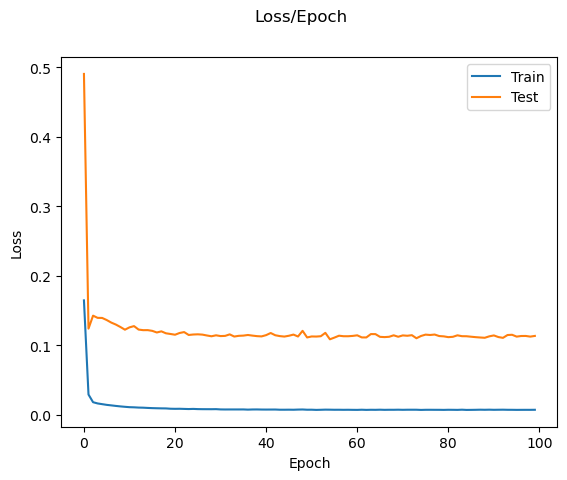

<Figure size 640x480 with 0 Axes>

In [18]:
models = ShuffleNetV2(n_class=30, input_size=96, width_mult=0.5)
l_m = L2Loss()
train(l_m, "best_shufflenet_v2_l2.pt")

At epoch 1/100. Total training loss:  0.349119  current loss:  0.282492  learning rate 0.01 current best validate loss:  0.282492
At epoch 2/100. Total training loss:  0.146126  current loss:  0.102833  learning rate 0.01 current best validate loss:  0.102833
At epoch 3/100. Total training loss:  0.119613  current loss:  0.131473  learning rate 0.01 current best validate loss:  0.102833
At epoch 4/100. Total training loss:  0.108498  current loss:  0.131501  learning rate 0.01 current best validate loss:  0.102833
At epoch 5/100. Total training loss:  0.101908  current loss:  0.117241  learning rate 0.01 current best validate loss:  0.102833
At epoch 6/100. Total training loss:  0.095134  current loss:  0.114560  learning rate 0.01 current best validate loss:  0.102833
At epoch 7/100. Total training loss:  0.090447  current loss:  0.108447  learning rate 0.01 current best validate loss:  0.102833
At epoch 8/100. Total training loss:  0.087138  current loss:  0.109184  learning rate 0.0

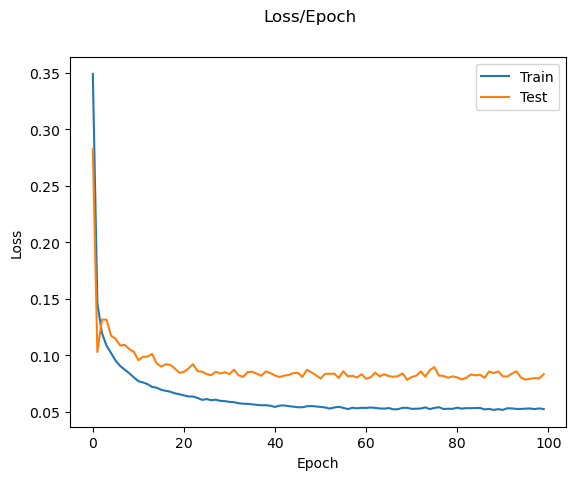

<Figure size 640x480 with 0 Axes>

In [19]:
models = ShuffleNetV2(n_class=30, input_size=96, width_mult=0.5)
l_m = nn.L1Loss()
train(l_m, "best_shufflenet_v2_l1.pt")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


At epoch 1/100. Total training loss:  11.843917  current loss:  199.143302  learning rate 0.01 current best validate loss:  199.143302
At epoch 2/100. Total training loss:  6.318059  current loss:  0.231753  learning rate 0.01 current best validate loss:  0.231753
At epoch 3/100. Total training loss:  4.315846  current loss:  0.151523  learning rate 0.01 current best validate loss:  0.151523
At epoch 4/100. Total training loss:  2.911630  current loss:  0.254399  learning rate 0.01 current best validate loss:  0.151523
At epoch 5/100. Total training loss:  2.218648  current loss:  0.074160  learning rate 0.01 current best validate loss:  0.074160
At epoch 6/100. Total training loss:  1.703802  current loss:  0.066221  learning rate 0.01 current best validate loss:  0.066221
At epoch 7/100. Total training loss:  1.450241  current loss:  0.075220  learning rate 0.01 current best validate loss:  0.066221
At epoch 8/100. Total training loss:  1.367383  current loss:  0.058316  learning rat

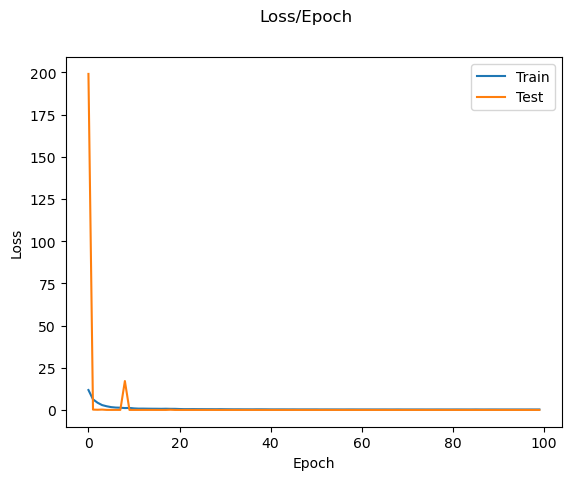

<Figure size 640x480 with 0 Axes>

In [20]:
models = ResNet18(num_classes=30, channels=3)
l_m = WingLoss(omega=30, epsilon=2)
train(l_m, "best_r50_wingl.pt")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


At epoch 1/100. Total training loss:  0.801150  current loss:  0.477747  learning rate 0.01 current best validate loss:  0.477747
At epoch 2/100. Total training loss:  0.212865  current loss:  0.631837  learning rate 0.01 current best validate loss:  0.477747
At epoch 3/100. Total training loss:  0.112141  current loss:  0.388781  learning rate 0.01 current best validate loss:  0.388781
At epoch 4/100. Total training loss:  0.070771  current loss:  0.318638  learning rate 0.01 current best validate loss:  0.318638
At epoch 5/100. Total training loss:  0.046913  current loss:  0.260284  learning rate 0.01 current best validate loss:  0.260284
At epoch 6/100. Total training loss:  0.038768  current loss:  0.243637  learning rate 0.01 current best validate loss:  0.243637
At epoch 7/100. Total training loss:  0.031454  current loss:  0.215667  learning rate 0.01 current best validate loss:  0.215667
At epoch 8/100. Total training loss:  0.027610  current loss:  0.202833  learning rate 0.0

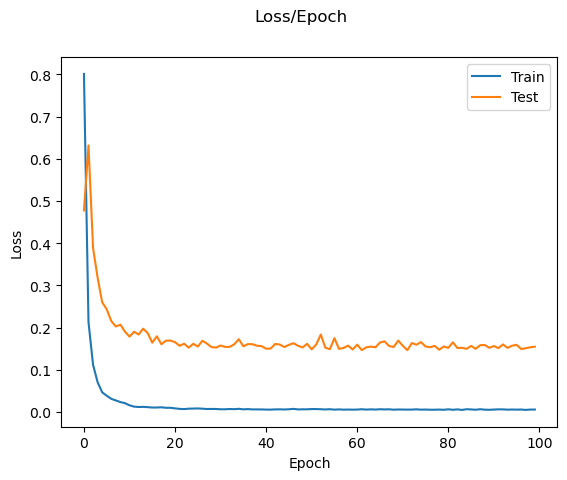

<Figure size 640x480 with 0 Axes>

In [21]:
models = ResNet18(num_classes=30, channels=3)
l_m = nn.MSELoss()
train(l_m, "best_r50_l2.pt")

In [22]:
models = ResNet18(num_classes=30, channels=3)
models.load_state_dict(torch.load('best_r50_wingl.pt', map_location=device), strict=False)
models.eval().to(device)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu): GELU(approximate='none')
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d

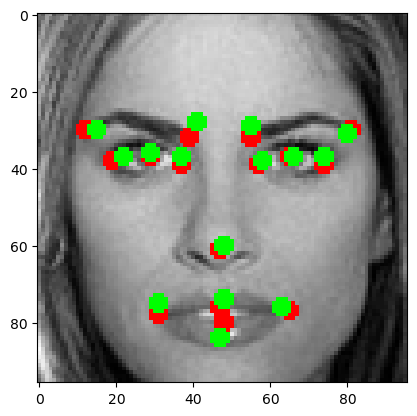

In [23]:
inputs, labels = next(iter(val_loader))  
inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

pred = models(inputs.to(device))
index = int(random.randint(0, len(inputs)-1))
show_image(inputs, labels, index, pred)

In [24]:
def postprocess(pred, img_w):
    pred = (pred) * img_w
    return pred

In [25]:
!pip install thop

In [26]:

from thop import clever_format
from thop import profile
input = torch.randn(1, 3, 96, 96).to(device)
flops, params = profile(models.eval(), inputs=(input, ))
flops, params = clever_format([flops, params], "%.3f")
print(flops, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
435.317M 14.023M


<Figure size 640x480 with 0 Axes>

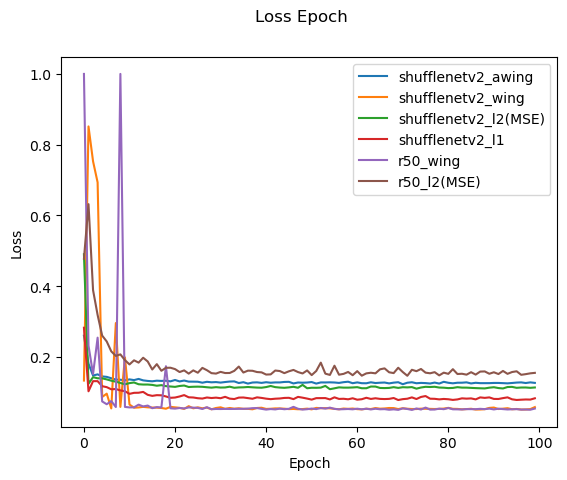

<Figure size 640x480 with 0 Axes>

In [27]:
def load_his(file_name):
    temp = None
    with open(file_name, "rb") as fp:
       temp = pickle.load(fp)
    return temp
shv2_awing = np.clip(np.asarray(load_his("best_shufflenet_v2_awingl")), 0., 1.)
shv2_wings = np.clip(np.asarray(load_his("best_shufflenet_v2_wingl")), 0., 1.)
shv2_l2 = np.clip(np.asarray(load_his("best_shufflenet_v2_l2")), 0., 1.)
shv2_l1 = np.clip(np.asarray(load_his("best_shufflenet_v2_l1")), 0., 1.)
r50_wingl = np.clip(np.asarray(load_his("best_r50_wingl")), 0., 1.)
r50_l2 = np.clip(np.asarray(load_his("best_r50_l2")), 0., 1.)

plt.clf()
plt.plot(shv2_awing)
plt.plot(shv2_wings)
plt.plot(shv2_l2)
plt.plot(shv2_l1)
plt.plot(r50_wingl)
plt.plot(r50_l2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.suptitle("Loss Epoch")
plt.legend(["shufflenetv2_awing", "shufflenetv2_wing", "shufflenetv2_l2(MSE)", "shufflenetv2_l1", "r50_wing", "r50_l2(MSE)"])
plt.figure()

In [28]:
print("Model shufflev2x0.5 use AdaptiveWingLoss best loss value are: ", min(shv2_awing))
print("Model shufflev2x0.5 use WingLoss best loss value are: ", min(shv2_wings))
print("Model shufflev2x0.5 use L2(MSE) best loss value are: ", min(shv2_l2))
print("Model shufflev2x0.5 use L1 best loss value are: ", min(shv2_l1))
print("Model R18 use WingLoss best loss value are: ", min(r50_wingl))
print("Model R18 use L2(MSE) best loss value are: ", min(r50_l2))

Model shufflev2x0.5 use AdaptiveWingLoss best loss value are:  0.12283562871154595
Model shufflev2x0.5 use WingLoss best loss value are:  0.0512310277635806
Model shufflev2x0.5 use L2(MSE) best loss value are:  0.10875571182583724
Model shufflev2x0.5 use L1 best loss value are:  0.07815494715610398
Model R18 use WingLoss best loss value are:  0.05015197944046924
Model R18 use L2(MSE) best loss value are:  0.14670779029156933
